Name: Charles Fawcett

Student ID: 14247617

In [249]:
#ALL import statements
import numpy as np
import pandas as pd
import apmodule as ap
import matplotlib.pyplot as plt
import matplotlib.ticker as mtickerc
import matplotlib.dates as mdates
from matplotlib.patches import Patch
from matplotlib.ticker import PercentFormatter
from sklearn import tree, metrics


In [250]:
#ALL custom functions

def quartile_performance(data: pd.DataFrame, return_name: str = "fut_ret") -> pd.DataFrame:
    mean_return = data[return_name].mean()*12
    volatility = data[return_name].std()*np.sqrt(12)
    rr_ratio = (data[return_name].mean()*12) / (data[return_name].std()*np.sqrt(12)) #added brackets compared to tutorial
    performance = pd.DataFrame({'Mean Ret': mean_return,
                                'Std Dev': volatility,
                                'RR Ratio': rr_ratio})
    return performance

def one_dollar_invested_plot(df: pd.DataFrame, title: str, legend_map: dict | None = None, save_as: None | str = None) -> None:
    ax = df.plot(figsize=(10, 6))
    ax.set_yscale('log')
    ax.set_title(title)
    ax.set_xlabel("Date")
    ax.set_ylabel("Portfolio Value ($, Log Scale)")
    ax.set_axisbelow(True)
    ax.yaxis.set_major_locator(mticker.LogLocator(base=10))
    ax.yaxis.set_minor_locator(mticker.LogLocator(base=10, subs=np.arange(2,10)*0.1))
    ax.grid(True, axis='y', linestyle=':', linewidth=1.2, alpha=0.75)
    ax.grid(True, axis='y', which='minor', linestyle=':', linewidth=0.6, alpha=0.65)
    ax.tick_params(axis='x', labelrotation=0)
    for lbl in ax.get_xticklabels():
        lbl.set_ha('center')
    ax.figure.tight_layout()

    # remap legend labels
    if legend_map is not None:
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles, [legend_map.get(l, l) for l in labels])

    if save_as:
        ax.figure.savefig(save_as, dpi=150, bbox_inches='tight')
    plt.show()
    plt.close(ax.figure)


def train_tree(data: pd.DataFrame, train_start_date: str = '1990-01-01', train_end_date: str = '2014-12-31', test_start_date: str = '2015-01-01', test_end_date: str = '2023-12-29', y_col: str = 'fut_ret', depth: int = 3):
    X = data.drop(columns=[y_col])
    y = data[y_col] > data.groupby('date')[y_col].transform('median')
    X_train = X.loc[pd.IndexSlice[:, train_start_date:train_end_date],:]
    X_test = X.loc[pd.IndexSlice[:, test_start_date:test_end_date],:]
    y_train = y.loc[pd.IndexSlice[:, train_start_date:train_end_date]]
    y_test = y.loc[pd.IndexSlice[:, test_start_date:test_end_date]]
    clf = tree.DecisionTreeClassifier(max_depth=depth)
    clf.fit(X_train, y_train)

    #calculate the feature importance
    # clf.feature_importances_
    features = pd.DataFrame(clf.feature_importances_, columns=['Feature Importance'], index=X.columns)

    # in sample predictions
    y_train_pred = clf.predict(X_train)
    # Out-of-sample predictions
    y_test_pred = clf.predict(X_test)
    os_pred = pd.Series(y_test_pred.astype('int64'), index = X_test.index).rename('Winner')
    ins_pred = pd.Series(y_train_pred.astype('int64'), index = X_train.index).rename('Winner')
    ret, os_dia = ap.ml_analysis(os_pred, prices.squeeze())
    print(os_dia)
    ir = os_dia.loc['RR Ratio', 'Active']

    ins_accuracy = metrics.accuracy_score(y_train, y_train_pred)
    os_accuracy = metrics.accuracy_score(y_test, y_test_pred)

    print(f'in sample accuracy: {ins_accuracy}, out of sample accuracy: {os_accuracy}')

    return clf, ins_accuracy, os_accuracy, ir, features, X.columns.to_list()


    

In [251]:
#Loading of ALL data files
factors = pd.read_csv('FACTORS.zip', parse_dates=['date']).set_index(['id', 'date'])
market_cap = pd.read_csv('Market_cap.zip', parse_dates=['date']).set_index(['id', 'date'])
names = pd.read_csv('names.zip').set_index('id')
prices = pd.read_csv('Prices.zip', parse_dates=['date']).set_index(['id', 'date'])
inflation = pd.read_csv('Inflation.csv', parse_dates=['date']).set_index(['date'])

factors.head()



C:\Users\Charles\AppData\Local\Temp\ipykernel_3168\810976339.py:6: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  inflation = pd.read_csv('Inflation.csv', parse_dates=['date']).set_index(['date'])


tvol    profit    safety
id    date                                    
10001 1996-07-31  1.145514 -0.612134 -0.475430
      1996-08-30  1.144505 -0.614493 -0.553341
      1996-09-30  1.144190 -1.327119 -0.697980
      1996-10-31  1.124252 -1.324461 -0.728012
      1996-11-29  1.123180 -1.321322 -0.721799

1. PREDICTIVE POWER OF INVESTMENT FACTORS


In [252]:
#calculating the future returns and storing this in a series
future_returns = np.log(prices['price'].groupby('id').shift(-1) / prices['price']).rename('fut_ret')

#split each factor into their own series
tvol_series = factors['tvol']
profit_series = factors['profit']
safety_series = factors['safety']

#merge each factor series with the future returns
tvol_data = tvol_series.to_frame().join(future_returns).dropna()
profit_data = profit_series.to_frame().join(future_returns).dropna()
safety_data = safety_series.to_frame().join(future_returns).dropna()

#number of bins for the quintile analysis
N = 4

#create the bins
tvol_data['tvol_group'] = tvol_data.groupby('date', group_keys=False)['tvol'].apply(lambda x: pd.qcut(x,N, labels=False))+1
profit_data['profit_group'] = profit_data.groupby('date', group_keys=False)['profit'].apply(lambda x: pd.qcut(x,N, labels=False))+1
safety_data['safety_group'] = safety_data.groupby('date', group_keys=False)['safety'].apply(lambda x: pd.qcut(x,N, labels=False))+1

#combine into one dataframe
groups = pd.concat(
    [tvol_data[['tvol_group']], profit_data[['profit_group']], safety_data[['safety_group']]],
    axis=1, join='inner'
)
data = groups.join(future_returns).dropna(subset=['fut_ret'])

data.tail()

tvol_group  profit_group  safety_group   fut_ret
id    date                                                        
93426 2023-08-31           3             3             4 -0.070144
      2023-09-29           3             3             4 -0.115403
      2023-10-31           3             3             4  0.018872
      2023-11-30           3             3             4  0.111019
      2023-12-29           3             3             4 -0.066438

          Volatility    Profit    Safety
bucket 1   -0.021710 -0.018614 -0.024625
bucket 2    0.045205  0.050647  0.057596
bucket 3    0.068058  0.070356  0.073744
bucket 4    0.099548  0.088744  0.084439
          Volatility    Profit    Safety
bucket 1   -0.089738 -0.089384 -0.100764
bucket 2    0.222275  0.273289  0.316513
bucket 3    0.366419  0.390119  0.422400
bucket 4    0.736208  0.512062  0.565365


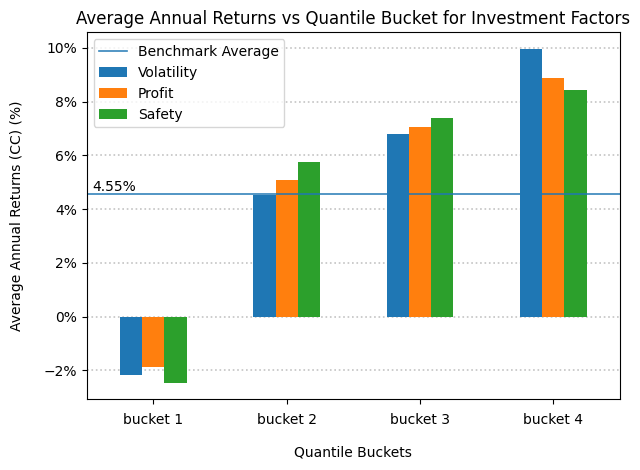

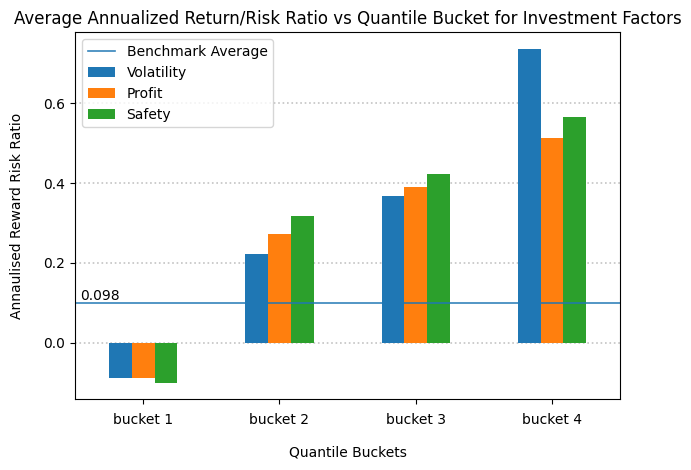

In [253]:
#calculate the average signal and the average future return and pass this to the quartile_performance function
tvol_perf = quartile_performance(tvol_data.groupby(['date', 'tvol_group']).mean().unstack(level=1))
profit_perf = quartile_performance(profit_data.groupby(['date', 'profit_group']).mean().unstack(level=1))
safety_perf = quartile_performance(safety_data.groupby(['date', 'safety_group']).mean().unstack(level=1))

#setup and creating the "Average Annual Returns vs Quantile Bucket for Investment Factors" graph (aar) ###########################################
#benchmark performance (using tvol)
avg_benchmark_returns = tvol_data['fut_ret'].mean()*12
benchmark_rr_ratio = (tvol_data['fut_ret'].mean()*12) / (tvol_data['fut_ret'].std()*np.sqrt(12))

bar_chart_col_names = [f"bucket {i+1}" for i in range(N)]
aar_bar_chart_df = pd.DataFrame({
    'Volatility': tvol_perf['Mean Ret'],
    'Profit': profit_perf['Mean Ret'],
    'Safety': safety_perf['Mean Ret']
})

aar_bar_chart_df.index = bar_chart_col_names

print(aar_bar_chart_df)

aar_bar_chart = aar_bar_chart_df.plot(kind='bar', rot=0)
aar_bar_chart.set_xlabel("Quantile Buckets", labelpad=14)
aar_bar_chart.set_ylabel("Average Annual Returns (CC) (%)", labelpad=14)
aar_bar_chart.set_title("Average Annual Returns vs Quantile Bucket for Investment Factors")
aar_bar_chart.yaxis.set_major_formatter(mticker.PercentFormatter(xmax=1.0, decimals=0))

aar_bar_chart.axhline(y=avg_benchmark_returns, linestyle='-', linewidth=1.2, alpha=0.9, label='Benchmark Average')
aar_bar_chart.text(0.01, avg_benchmark_returns, f'{avg_benchmark_returns:.2%}',
        transform=aar_bar_chart.get_yaxis_transform(),
        ha='left', va='bottom', clip_on=False)
aar_bar_chart.legend()

aar_bar_chart.set_axisbelow(True)
aar_bar_chart.grid(True, axis='y', linestyle=':', linewidth=1.2, alpha=0.75)
for lbl in aar_bar_chart.get_xticklabels():
    lbl.set_ha('center')   # default for bars, but explicit is fine
aar_bar_chart.tick_params(axis='x', pad=6)  # a little space from the axis
aar_bar_chart.figure.tight_layout()

#setup and creating the "Risk to Reward ratio vs Quintile Bucket for Investment Factors" (rrr)
rrr_bar_chart = pd.DataFrame({
    'Volatility': tvol_perf['RR Ratio'],
    'Profit': profit_perf['RR Ratio'],
    'Safety': safety_perf['RR Ratio']
})

rrr_bar_chart.index = bar_chart_col_names

print(rrr_bar_chart)

rrr_bar_chart = rrr_bar_chart.plot(kind='bar', rot=0)
rrr_bar_chart.set_xlabel("Quantile Buckets", labelpad=14)
rrr_bar_chart.set_ylabel("Annaulised Reward Risk Ratio", labelpad=14)
rrr_bar_chart.set_title("Average Annualized Return/Risk Ratio vs Quantile Bucket for Investment Factors")

rrr_bar_chart.axhline(y=benchmark_rr_ratio, linestyle='-', linewidth=1.2, alpha=0.9, label='Benchmark Average')
rrr_bar_chart.text(0.01, benchmark_rr_ratio, f'{benchmark_rr_ratio:.2}',
        transform=rrr_bar_chart.get_yaxis_transform(),
        ha='left', va='bottom', clip_on=False)
rrr_bar_chart.legend()

rrr_bar_chart.set_axisbelow(True)
rrr_bar_chart.grid(True, axis='y', linestyle=':', linewidth=1.2, alpha=0.75)
for lbl in rrr_bar_chart.get_xticklabels():
    lbl.set_ha('center')
rrr_bar_chart.tick_params(axis='x', pad=6)
rrr_bar_chart.figure.tight_layout()

#save both of the graphs
aar_bar_chart.figure.savefig("aar_bar_chart.png", dpi=150, bbox_inches='tight')
rrr_bar_chart.figure.savefig("rrr_bar_chart.png", dpi=150, bbox_inches='tight')


In [254]:
data.head()

tvol_group  profit_group  safety_group   fut_ret
id    date                                                        
10001 1996-07-31           4             1             2  0.037458
      1996-08-30           4             1             2  0.040916
      1996-09-30           4             1             1 -0.028987
      1996-10-31           4             1             1  0.028988
      1996-11-29           4             1             1 -0.061268

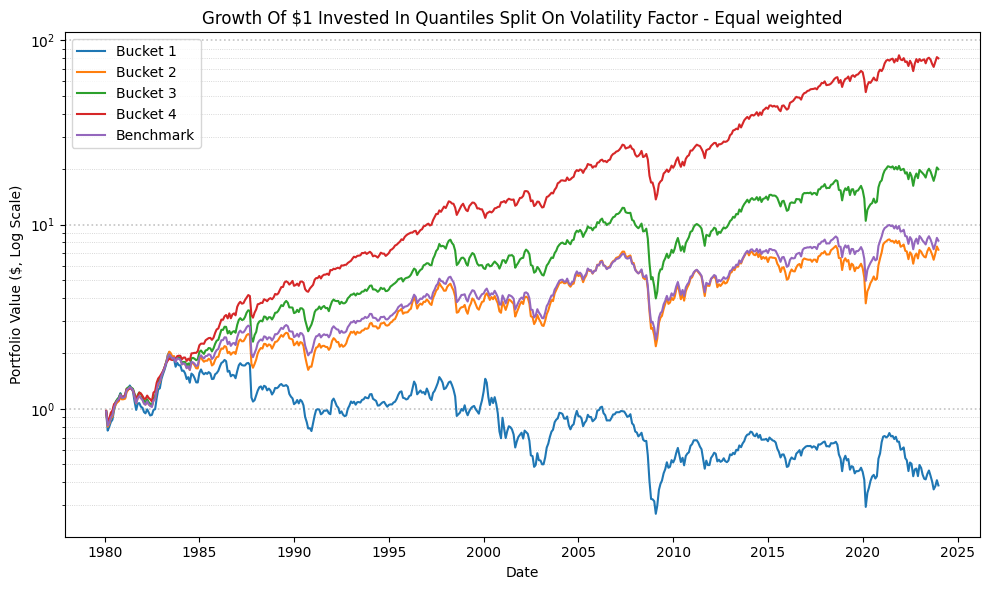

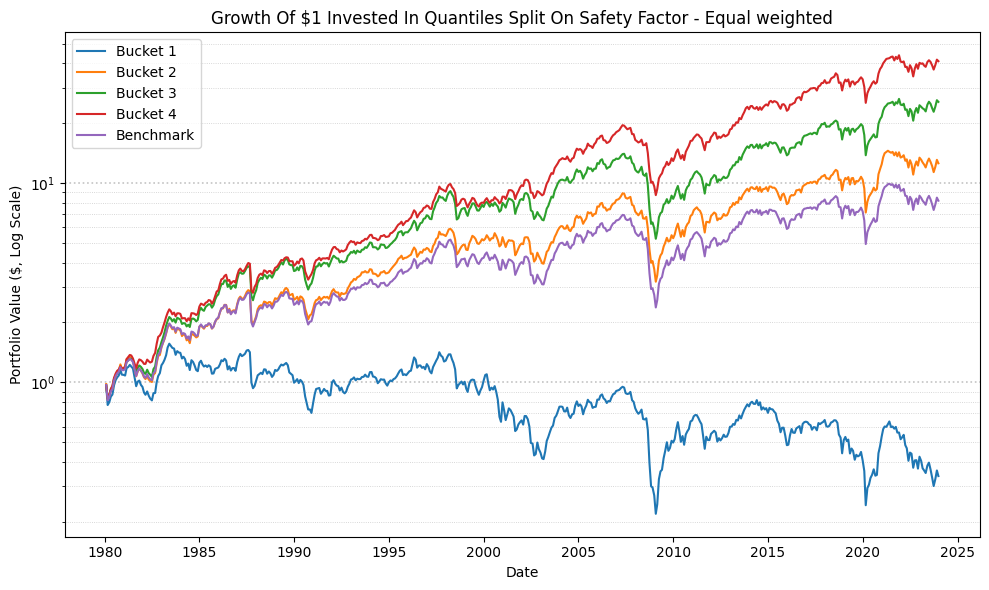

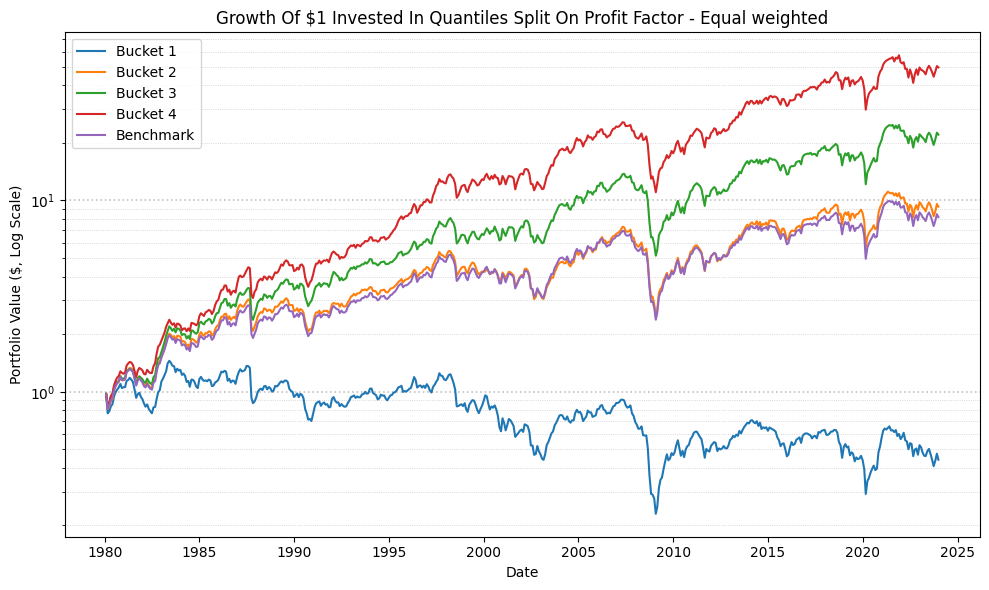

In [255]:
#now let's visualise the returns on a $1 portfolio in each bucket and factor
bench_port = data['fut_ret'].groupby('date').mean().cumsum().apply(np.exp).to_frame()
tvol_port = data.groupby(['date', 'tvol_group']).mean().unstack(level=1)['fut_ret'].cumsum().apply(np.exp)
tvol_port = tvol_port.join(bench_port)
safety_port = data.groupby(['date', 'safety_group']).mean().unstack(level=1)['fut_ret'].cumsum().apply(np.exp)
safety_port = safety_port.join(bench_port)
profit_port = data.groupby(['date', 'profit_group']).mean().unstack(level=1)['fut_ret'].cumsum().apply(np.exp)
profit_port = profit_port.join(bench_port)

legend_map = {}
for i in range(0, N):
    legend_map[f"{i+1}"] = f"Bucket {i+1}"
legend_map["fut_ret"] = "Benchmark"

#plot each factor
one_dollar_invested_plot(tvol_port, "Growth Of $1 Invested In Quantiles Split On Volatility Factor - Equal weighted", legend_map=legend_map, save_as="Growth Of $1 Invested In Quantiles Split On Volatility Factor - Equal weighted.png")
one_dollar_invested_plot(safety_port, "Growth Of $1 Invested In Quantiles Split On Safety Factor - Equal weighted", legend_map=legend_map, save_as="Growth Of $1 Invested In Quantiles Split On Safety Factor - Equal weighted.png")
one_dollar_invested_plot(profit_port, "Growth Of $1 Invested In Quantiles Split On Profit Factor - Equal weighted", legend_map=legend_map, save_as="Growth Of $1 Invested In Quantiles Split On Profit Factor - Equal weighted.png")

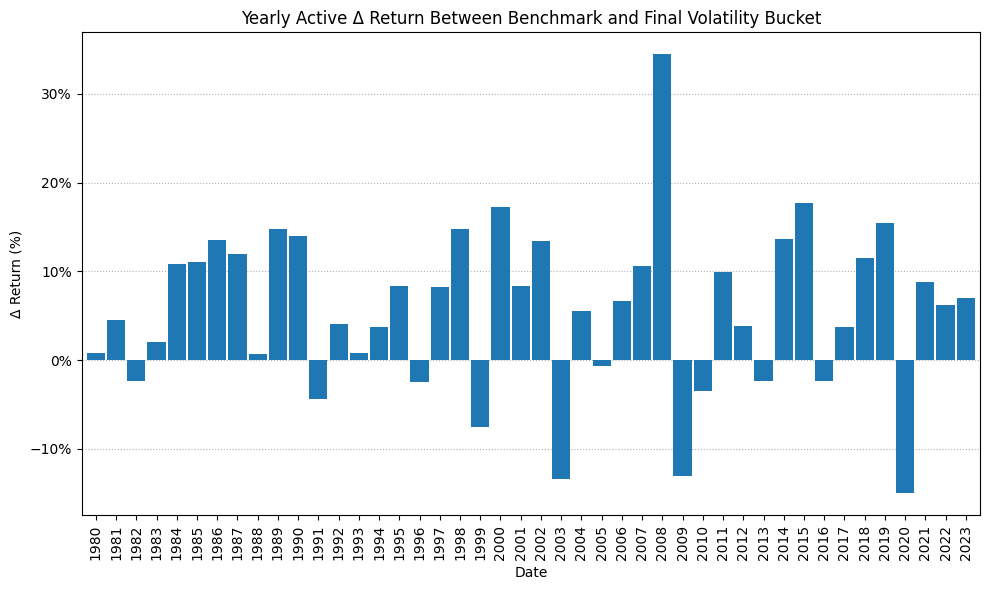

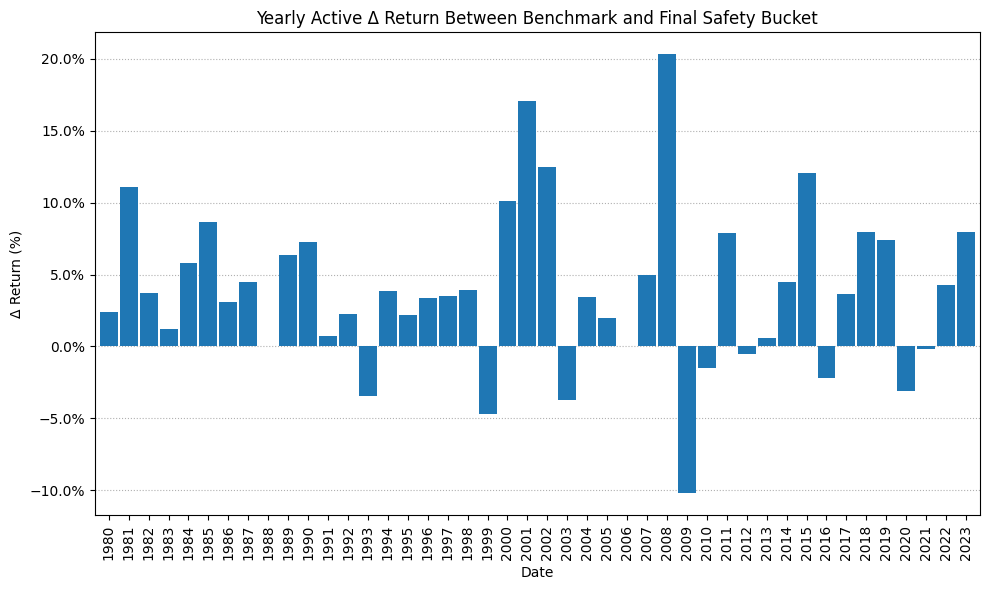

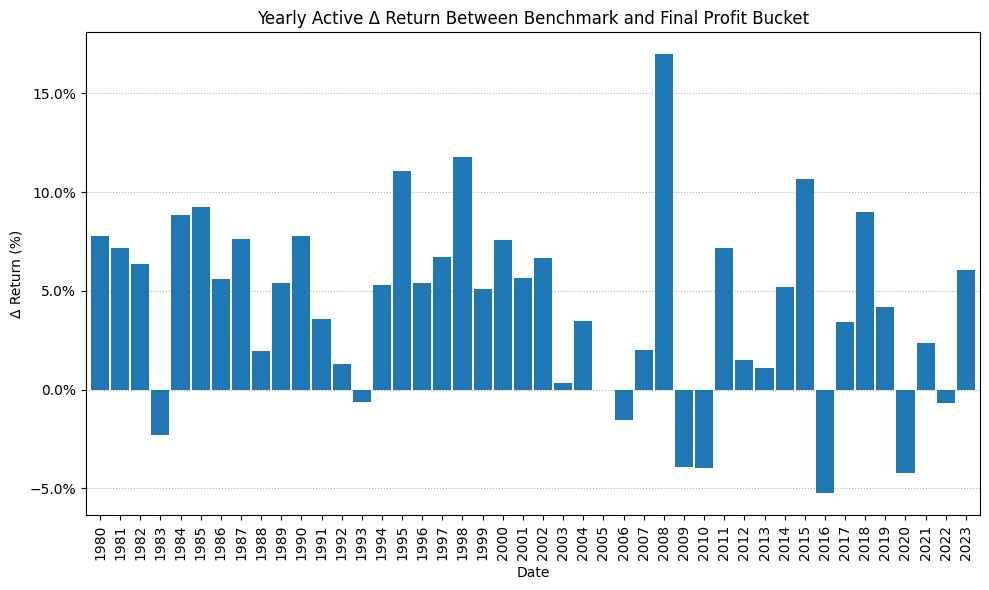

In [256]:
#let's take a closer look at the year by year performance by looking at the differnce between bucket 4 and the benchmark year by year for each factor

benchmark_ret = data['fut_ret'].groupby('date').mean().to_frame()

#yby for year by year
tvol_active = data.groupby(['date', 'tvol_group']).mean().unstack(level=1)["fut_ret"]
tvol_active = tvol_active.join(benchmark_ret).dropna()
tvol_active["active"] = tvol_active[N] - tvol_active["fut_ret"]
tvol_yby = tvol_active.resample('YE').sum().apply(np.expm1)
tvol_yby.index = tvol_yby.index.year

safety_active = data.groupby(['date', 'safety_group']).mean().unstack(level=1)["fut_ret"]
safety_active = safety_active.join(benchmark_ret).dropna()
safety_active["active"] = safety_active[N] - safety_active["fut_ret"]
safety_yby = safety_active.resample('YE').sum().apply(np.expm1)
safety_yby.index = safety_yby.index.year

profit_active = data.groupby(['date', 'profit_group']).mean().unstack(level=1)["fut_ret"]
profit_active = profit_active.join(benchmark_ret).dropna()
profit_active["active"] = profit_active[N] - profit_active["fut_ret"]
profit_yby = profit_active.resample('YE').sum().apply(np.expm1)
profit_yby.index = profit_yby.index.year

#take the active returns and put them in a dataframe for future use
actives = pd.DataFrame()
actives["tvol"] = tvol_active['active'] 
actives["safety"] = safety_active['active'] 
actives["profit"] = profit_active['active'] 

#bar charts
tvol_yby_bar_return = tvol_yby['active'].plot(figsize=(10,6), kind='bar', width=0.9)
tvol_yby_bar_return.set_title("Yearly Active Δ Return Between Benchmark and Final Volatility Bucket")
tvol_yby_bar_return.set_xlabel("Date")
tvol_yby_bar_return.set_ylabel("Δ Return (%)")
tvol_yby_bar_return.grid(True, axis='y', linestyle=':', linewidth=0.8)
tvol_yby_bar_return.set_axisbelow(True)
tvol_yby_bar_return.yaxis.set_major_formatter(PercentFormatter(xmax=1.0))
plt.tight_layout()
tvol_yby_bar_return.figure.savefig("tvol_yby_bar_return.png", dpi=150, bbox_inches='tight')
plt.show()

safety_yby_bar_return = safety_yby['active'].plot(figsize=(10,6), kind='bar', width=0.9)
safety_yby_bar_return.set_title("Yearly Active Δ Return Between Benchmark and Final Safety Bucket")
safety_yby_bar_return.set_xlabel("Date")
safety_yby_bar_return.set_ylabel("Δ Return (%)")
safety_yby_bar_return.grid(True, axis='y', linestyle=':', linewidth=0.8)
safety_yby_bar_return.set_axisbelow(True)
safety_yby_bar_return.yaxis.set_major_formatter(PercentFormatter(xmax=1.0))
plt.tight_layout()
safety_yby_bar_return.figure.savefig("safety_yby_bar_return.png", dpi=150, bbox_inches='tight')
plt.show()

profit_yby_bar_return = profit_yby['active'].plot(figsize=(10,6), kind='bar', width=0.9)
profit_yby_bar_return.set_title("Yearly Active Δ Return Between Benchmark and Final Profit Bucket")
profit_yby_bar_return.set_xlabel("Date")
profit_yby_bar_return.set_ylabel("Δ Return (%)")
profit_yby_bar_return.grid(True, axis='y', linestyle=':', linewidth=0.8)
profit_yby_bar_return.set_axisbelow(True)
profit_yby_bar_return.yaxis.set_major_formatter(PercentFormatter(xmax=1.0))
plt.tight_layout()
profit_yby_bar_return.figure.savefig("profit_yby_bar_return.png", dpi=150, bbox_inches='tight')
plt.show()




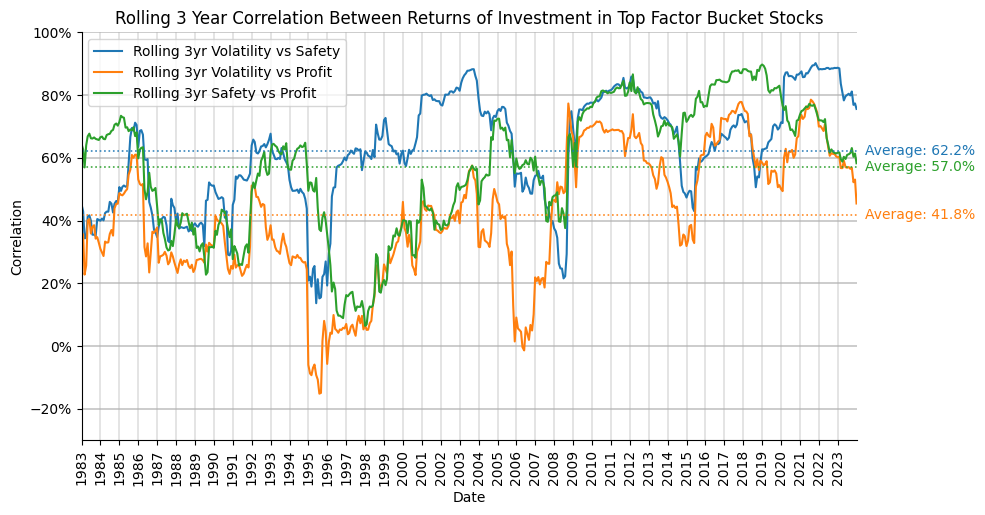

In [257]:
#now to calculate the correlation between the factors!
roll_corr = pd.DataFrame()
roll_corr['tvol_safety'] = actives['tvol'].rolling(36).corr(actives['safety'])
roll_corr['tvol_profit'] = actives['tvol'].rolling(36).corr(actives['profit'])
roll_corr['safety_profit'] = actives['safety'].rolling(36).corr(actives['profit'])

averages = [roll_corr['tvol_safety'].mean(), roll_corr['tvol_profit'].mean(), roll_corr['safety_profit'].mean()]

roll_corr_plot = roll_corr.plot(figsize=(10, 6))
roll_corr_plot.yaxis.set_major_formatter(mticker.PercentFormatter(xmax=1.0, decimals=0))
roll_corr_plot.set_ylim(-.3, 1)
roll_corr_plot.tick_params(axis='x', labelrotation=90)
roll_corr_plot.spines['top'].set_visible(False)
roll_corr_plot.spines['right'].set_visible(False)
first_valid = roll_corr.index[roll_corr.notna().any(axis=1)][0]
roll_corr_plot.xaxis.set_major_locator(mdates.YearLocator(base=1, month=1, day=1))
roll_corr_plot.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
roll_corr_plot.set_xlim(left=first_valid, right=roll_corr.index.max())  # no extra room on the right
roll_corr_plot.margins(x=0) 

legend_map = {
        "tvol_safety" : "Rolling 3yr Volatility vs Safety",
        "tvol_profit" : "Rolling 3yr Volatility vs Profit",
        "safety_profit" : "Rolling 3yr Safety vs Profit",
}
handles, labels = roll_corr_plot.get_legend_handles_labels()
roll_corr_plot.legend(handles, [legend_map.get(l, l) for l in labels])

y = float(averages[0])
c = 'tab:blue'
x0 = roll_corr.index.sort_values()[35]
x1 = roll_corr.index.max()
roll_corr_plot.hlines(y=y, xmin=x0, xmax=x1,colors=c, linestyles=':', linewidth=1.2, alpha=0.9)
roll_corr_plot.annotate(f'Average: {y:.1%}',
                        xy=(1, y),                         # x=right edge of axes
                        xycoords=('axes fraction', 'data'),# x in axes coords, y in data coords
                        xytext=(6, 0), textcoords='offset points',
                        ha='left', va='center',
                        color=c,
                        bbox=dict(boxstyle='round,pad=0.2', fc='white', ec='none'),
                        clip_on=False)

y = float(averages[1])
c = 'tab:orange'
x0 = roll_corr.index.sort_values()[35]
x1 = roll_corr.index.max()
roll_corr_plot.hlines(y=y, xmin=x0, xmax=x1,colors=c, linestyles=':', linewidth=1.2, alpha=0.9)
roll_corr_plot.annotate(f'Average: {y:.1%}',
                        xy=(1, y),                         # x=right edge of axes
                        xycoords=('axes fraction', 'data'),# x in axes coords, y in data coords
                        xytext=(6, 0), textcoords='offset points',
                        ha='left', va='center',
                        color=c,
                        bbox=dict(boxstyle='round,pad=0.2', fc='white', ec='none'),
                        clip_on=False)

y = float(averages[2])
c = 'tab:green'
x0 = roll_corr.index.sort_values()[35]
x1 = roll_corr.index.max()
roll_corr_plot.hlines(y=y, xmin=x0, xmax=x1,colors=c, linestyles=':', linewidth=1.2, alpha=0.9)
roll_corr_plot.annotate(f'Average: {y:.1%}',
                        xy=(1, y),                         # x=right edge of axes
                        xycoords=('axes fraction', 'data'),# x in axes coords, y in data coords
                        xytext=(6, 0), textcoords='offset points',
                        ha='left', va='center',
                        color=c,
                        bbox=dict(boxstyle='round,pad=0.2', fc='white', ec='none'),
                        clip_on=False)


for lbl in roll_corr_plot.get_xticklabels():
        lbl.set_ha('center')

roll_corr_plot.grid(True, axis='y', linestyle='-', linewidth=1.2, alpha=0.75)
roll_corr_plot.grid(True, axis='y', which='minor', linestyle=':', linewidth=0.6, alpha=0.65)
roll_corr_plot.grid(True, axis='x', linestyle='-', linewidth=1.2, alpha=0.4)
roll_corr_plot.grid(True, axis='x', which='minor', linestyle=':', linewidth=0.6, alpha=0.4)


roll_corr_plot.set_xlabel('Date')
roll_corr_plot.set_ylabel('Correlation')
roll_corr_plot.set_title('Rolling 3 Year Correlation Between Returns of Investment in Top Factor Bucket Stocks')

roll_corr_plot.figure.savefig("roll_corr_plot.png", dpi=150, bbox_inches='tight')


In [258]:
#raw factor correlation table
print(factors.corr('spearman'))

            tvol    profit    safety
tvol    1.000000  0.091074  0.124742
profit  0.091074  1.000000  0.424398
safety  0.124742  0.424398  1.000000


2. EFFECT OF MACROECONOMIC ENVIRONMENT


In [259]:
inflation.head()

,Inflation
date,
1980-01-31,13.599493
1980-02-29,14.331667
1980-03-31,14.755205
1980-04-30,15.115273
1980-05-30,15.774167


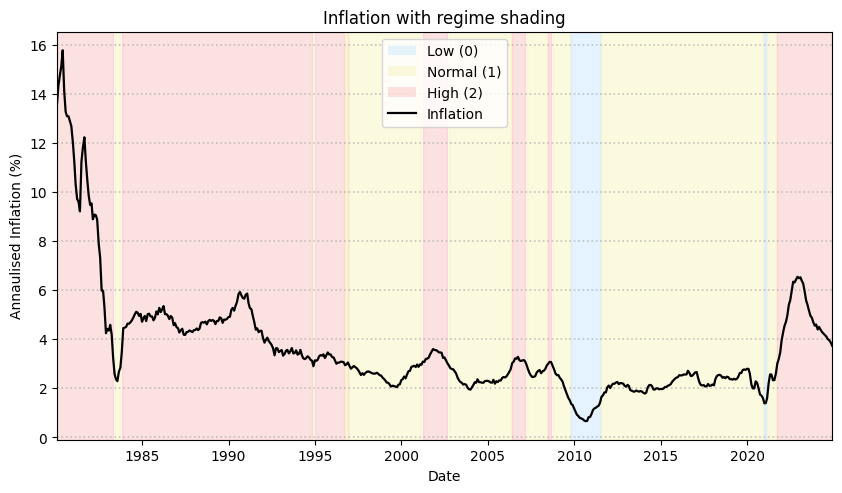

In [260]:
#Inflation!

# low rate = 0, normal rate = 1, high rate  = 2
inflation['inf_state'] = 1
inflation.loc[inflation["Inflation"] < 1.5, 'inf_state'] = 0
inflation.loc[inflation['Inflation'] >= 3, 'inf_state'] = 2

infl_plt = inflation['Inflation'].plot(figsize=(10,6), lw=1.6, color='black',
                                 title='Inflation with regime shading')

# set x-axis to the exact data range
xmin, xmax = inflation.index.min(), inflation.index.max()
infl_plt.set_xlim(xmin, xmax)

# grid
infl_plt.grid(True, axis='y', linestyle=':', linewidth=1.2, alpha=0.75)
infl_plt.grid(True, axis='y', which='minor', linestyle=':', linewidth=0.6, alpha=0.65)

# colours per state
state_cols = {0: "#b4deff",  # low
              1: "#f4eea3",  # normal
              2: "#f9abab"}  # high

# find contiguous blocks of the same state
blocks = (inflation['inf_state'].ne(inflation['inf_state'].shift())).cumsum()

# shade each block
for _, seg in inflation.groupby(blocks):
    st = int(seg['inf_state'].iloc[0])
    infl_plt.axvspan(seg.index[0], seg.index[-1], color=state_cols[st], alpha=0.35, zorder=0)

# centre and format year labels horizontally
infl_plt.xaxis.set_major_locator(mdates.YearLocator(5))
infl_plt.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# keep labels horizontal and centred (optional)
for lbl in infl_plt.get_xticklabels():
    lbl.set_rotation(0)
    lbl.set_ha('center')

# legend for background colours
handles = [Patch(facecolor=state_cols[0], edgecolor='none', alpha=0.35, label='Low (0)'),
           Patch(facecolor=state_cols[1], edgecolor='none', alpha=0.35, label='Normal (1)'),
           Patch(facecolor=state_cols[2], edgecolor='none', alpha=0.35, label='High (2)')]
infl_plt.legend(handles=handles + [infl_plt.lines[0]], labels=[h.get_label() for h in handles] + ['Inflation'],
          loc='best')

infl_plt.set_ylabel('Annaulised Inflation (%)')
infl_plt.set_xlabel('Date')

infl_plt.figure.savefig("infl_plt.png", dpi=150, bbox_inches='tight')

In [261]:
#re calculate the buckets (in case N!=4 above)
tvol_series = factors['tvol']
profit_series = factors['profit']
safety_series = factors['safety']

#merge each factor series with the future returns
tvol_data = tvol_series.to_frame().join(future_returns).dropna()
profit_data = profit_series.to_frame().join(future_returns).dropna()
safety_data = safety_series.to_frame().join(future_returns).dropna()

#number of bins for the quartile inflation analysis
N = 4

#create the bins
tvol_data['tvol_group'] = tvol_data.groupby('date', group_keys=False)['tvol'].apply(lambda x: pd.qcut(x,N, labels=False))+1
profit_data['profit_group'] = profit_data.groupby('date', group_keys=False)['profit'].apply(lambda x: pd.qcut(x,N, labels=False))+1
safety_data['safety_group'] = safety_data.groupby('date', group_keys=False)['safety'].apply(lambda x: pd.qcut(x,N, labels=False))+1

#combine into one dataframe
groups = pd.concat(
    [tvol_data[['tvol_group']], profit_data[['profit_group']], safety_data[['safety_group']]],
    axis=1, join='inner'
)
data = groups.join(future_returns).dropna(subset=['fut_ret'])

#join the inflation information
data = data.join(inflation['inf_state'])

data.head()
# print(data['inf_state'].value_counts())

tvol_group  profit_group  safety_group   fut_ret  inf_state
id    date                                                                   
10001 1996-07-31           4             1             2  0.037458          2
      1996-08-30           4             1             2  0.040916          2
      1996-09-30           4             1             1 -0.028987          1
      1996-10-31           4             1             1  0.028988          1
      1996-11-29           4             1             1 -0.061268          2

In [262]:
# test = data.groupby(['date', 'inf_state'])
factor_prefixs = ['tvol_', 'profit_', 'safety_']

tvol_b_ret = (data.groupby(['date','tvol_group'])['fut_ret'].mean().unstack('tvol_group'))
tvol_b_ret = tvol_b_ret.add_prefix('tvol_')

profit_b_ret = (data.groupby(['date','profit_group'])['fut_ret'].mean().unstack('profit_group'))
profit_b_ret = profit_b_ret.add_prefix('profit_')

safety_b_ret = (data.groupby(['date','safety_group'])['fut_ret'].mean().unstack('safety_group'))
safety_b_ret = safety_b_ret.add_prefix('safety_')

inf = data.groupby('date')['inf_state'].first()
inf_state_returns = tvol_b_ret.join(profit_b_ret).join(safety_b_ret).join(inf)

#calculate series for the top quartile performance (tqp) for each inflation state
tqp_per_state = pd.DataFrame()

for factor in range(0, 3):
    for state in range(0, 3):
        column_name = f'{factor_prefixs[factor]}4_inf{state}'
        tqp_per_state[column_name] = inf_state_returns[f'{factor_prefixs[factor]}4'].where(inf_state_returns['inf_state'].eq(state))

bench_ret = data['fut_ret'].groupby('date').mean()
tqp_per_state = tqp_per_state.join(bench_ret)

tqp_active = (
    tqp_per_state.filter(like='_inf')   # all factor-by-inflation cols
    .sub(tqp_per_state['fut_ret'], axis=0)
    .add_suffix('_active')
)

info_ratio = (tqp_active.mean()*12)/(tqp_active.std()*np.sqrt(12))
info_ratio.name = "info_ratio"
print(info_ratio)


summary = pd.DataFrame({
    'n'      : tqp_active.count(),          # non-NaN months
    'mean_m' : tqp_active.mean(),           # monthly mean active
    'sd_m'   : tqp_active.std(ddof=1),      # monthly std (sample)
})

summary['mean_a'] = (np.exp(summary['mean_m'] * 12) - 1)*100 #calculing annualised arithmetic returns from monthly log returns

# 2) Standard error and t-stat of the mean (H0: mean == 0)
summary['se_m'] = summary['sd_m'] / np.sqrt(summary['n'])
summary['t_stat_mean'] = summary['mean_m'] / summary['se_m']

summary = summary.join(info_ratio.to_frame())

summary # to show low T_stat_mean and statistical significance of inflation state 2


tvol_4_inf0_active     -0.872323
tvol_4_inf1_active      0.585254
tvol_4_inf2_active      0.847530
profit_4_inf0_active   -0.646323
profit_4_inf1_active    0.939362
profit_4_inf2_active    1.602335
safety_4_inf0_active   -0.548634
safety_4_inf1_active    0.581998
safety_4_inf2_active    1.126126
Name: info_ratio, dtype: float64


,n,mean_m,sd_m,mean_a,se_m,t_stat_mean,info_ratio
tvol_4_inf0_active,23,-0.005438,0.021593,-6.316753,0.004503,-1.207676,-0.872323
tvol_4_inf1_active,251,0.004631,0.027411,5.714621,0.001730,2.676645,0.585254
tvol_4_inf2_active,254,0.004886,0.019971,6.038727,0.001253,3.899251,0.847530
profit_4_inf0_active,23,-0.002033,0.010895,-2.409726,0.002272,-0.894794,-0.646323
profit_4_inf1_active,251,0.003052,0.011255,3.730254,0.000710,4.296148,0.939362
profit_4_inf2_active,254,0.004267,0.009224,5.253358,0.000579,7.371903,1.602335
safety_4_inf0_active,23,-0.002527,0.015957,-2.987229,0.003327,-0.759549,-0.548634
safety_4_inf1_active,251,0.002843,0.016921,3.470400,0.001068,2.661754,0.581998
safety_4_inf2_active,254,0.003772,0.011604,4.630797,0.000728,5.180995,1.126126


3. BACK TESTING RESULTS


              Benchmark  tvol_active  safety_active  profit_active
Mean Return    0.071975     0.009355       0.008477       0.016307
St. Dev.       0.140972     0.048045       0.053034       0.043318
RR Ratio       0.510561     0.194716       0.159838       0.376437
% Positive     0.634804     0.502451       0.507353       0.529412
Worst Month   -0.186303    -0.070549      -0.075224      -0.039940
Best Month     0.109437     0.113620       0.063172       0.048463
Max DrawDown  -0.608557    -0.130479      -0.147880      -0.117684


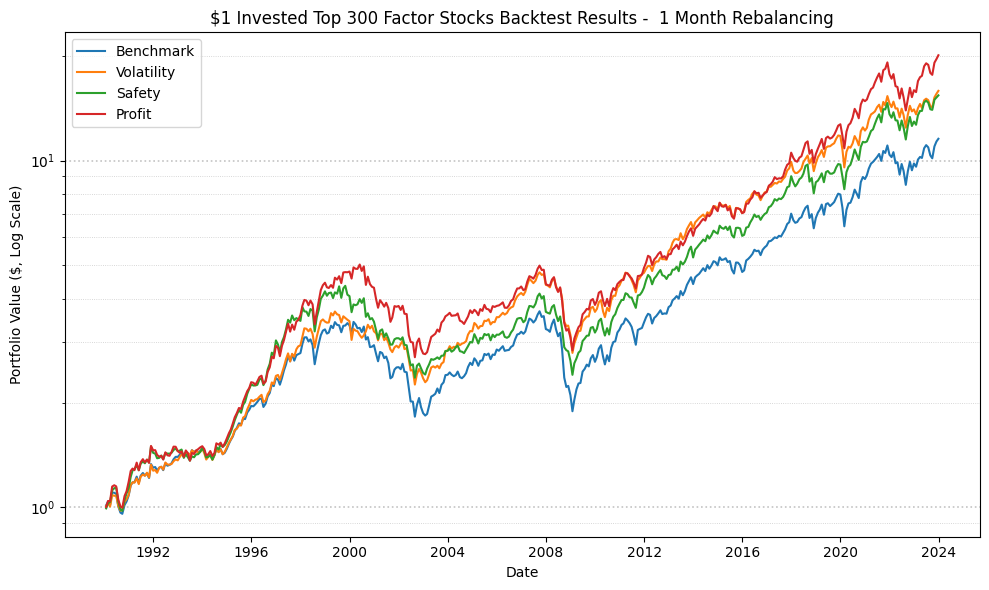

In [263]:
tvol_monthly_returns, tvol_turnover, tvol_composition, tvol_performance = ap.backtesting(factors['tvol'], prices['price'], market_cap['market_cap'], start='1990-01-01', end='2023-12-31', frequency=1, t_cost=0.0015, N=300)
safety_monthly_returns, safety_turnover, safety_composition, safety_performance = ap.backtesting(factors['safety'], prices['price'], market_cap['market_cap'], start='1990-01-01', end='2023-12-31', frequency=1, t_cost=0.0015, N=300)
profit_monthly_returns, profit_turnover, profit_composition, profit_performance = ap.backtesting(factors['profit'], prices['price'], market_cap['market_cap'], start='1990-01-01', end='2023-12-31', frequency=1, t_cost=0.0015, N=300)

bt_perf_table = pd.DataFrame()
bt_perf_table['Benchmark'] = tvol_performance['Benchmark']
bt_perf_table['tvol_active'] = tvol_performance['Active']
bt_perf_table['safety_active'] = safety_performance['Active']
bt_perf_table['profit_active'] = profit_performance['Active']
print(bt_perf_table)

tvol_bt_port = tvol_monthly_returns.cumsum().apply(np.exp)
safety_bt_port = safety_monthly_returns.cumsum().apply(np.exp)
profit_bt_port = profit_monthly_returns.cumsum().apply(np.exp)

bt_plot_perf = pd.DataFrame()
bt_plot_perf['Benchmark'] = tvol_bt_port['Benchmark'] 
bt_plot_perf['Volatility'] = tvol_bt_port['Portfolio'] 
bt_plot_perf['Safety'] = safety_bt_port['Portfolio'] 
bt_plot_perf['Profit'] = profit_bt_port['Portfolio'] 

one_dollar_invested_plot(bt_plot_perf, "$1 Invested Top 300 Factor Stocks Backtest Results -  1 Month Rebalancing", save_as="$1 Invested Top 300 Factor Stocks Backtest Results -  1 Month Rebalancing.png")

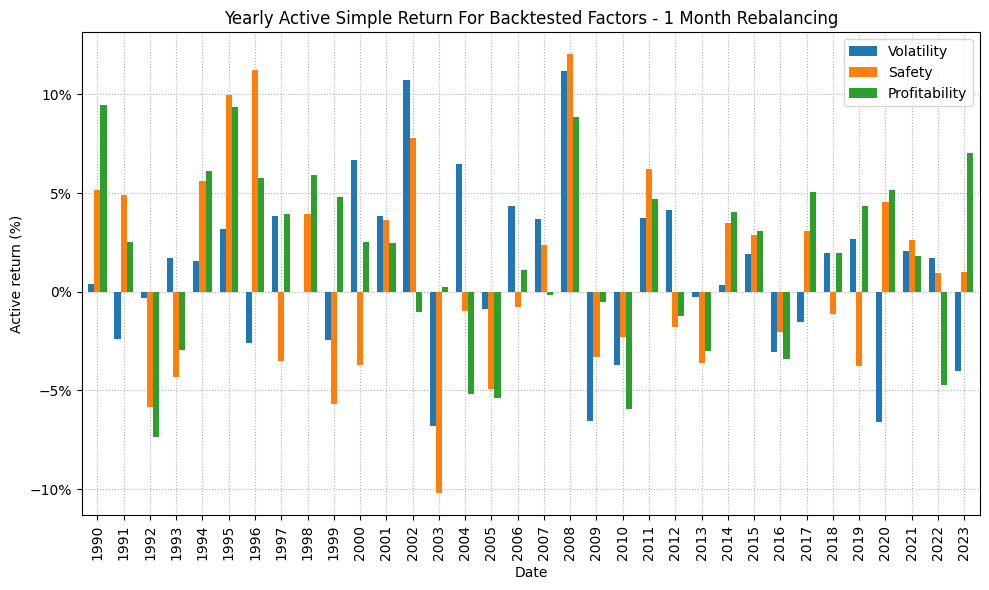

In [264]:
bt_yby = pd.DataFrame({
    'Volatility':    tvol_monthly_returns['Active'].resample('YE').sum(),
    'Safety':        safety_monthly_returns['Active'].resample('YE').sum(),
    'Profitability': profit_monthly_returns['Active'].resample('YE').sum(),
}).apply(np.expm1)
bt_yby.index = bt_yby.index.year

bt_yby_bar = bt_yby.plot(figsize=(10, 6), kind='bar',  width=0.7)
bt_yby_bar.set_title("Yearly Active Simple Return For Backtested Factors - 1 Month Rebalancing")
bt_yby_bar.set_xlabel("Date")
bt_yby_bar.set_ylabel("Active return (%)")
bt_yby_bar.grid(True, axis='both', linestyle=':', linewidth=0.8)
bt_yby_bar.set_axisbelow(True)
plt.tight_layout()
bt_yby_bar.yaxis.set_major_formatter(mticker.PercentFormatter(xmax=1.0, decimals=0))
bt_yby_bar.figure.savefig("bt_yby_bar.png", dpi=150, bbox_inches='tight')
plt.show()

4. REBALANCING FREQUENCY OPTIMISATION


In [265]:
rebalancing_freq = {
    'tvol': 0,
    'safety': 0,
    'profit': 0,
}
factor_names = ['tvol', 'safety', 'profit']
frequencies = range(1, 7)
ir_values = pd.DataFrame(index=frequencies, columns=factor_names, dtype=float)

skip_optimisation = False
if skip_optimisation is not True:
    for factor in factor_names:
        max_IC = -np.inf
        for frequency in frequencies:
            print(f'calculating {factor} frequency: {frequency}')
            _, _, _, perf = ap.backtesting(factors[factor], prices['price'], market_cap['market_cap'], start='1990-01-01', end='2023-12-31', frequency=frequency, t_cost=0.0015, N=300)
            ir_values.loc[frequency, factor] = perf.loc['RR Ratio', 'Active']
            if perf.loc['RR Ratio', 'Active'] > max_IC:
                max_IC = perf.loc['RR Ratio', 'Active']
                rebalancing_freq[factor] = frequency

    print(rebalancing_freq)


calculating tvol frequency: 1
calculating tvol frequency: 2
calculating tvol frequency: 3
calculating tvol frequency: 4
calculating tvol frequency: 5
calculating tvol frequency: 6
calculating safety frequency: 1
calculating safety frequency: 2
calculating safety frequency: 3
calculating safety frequency: 4
calculating safety frequency: 5
calculating safety frequency: 6
calculating profit frequency: 1
calculating profit frequency: 2
calculating profit frequency: 3
calculating profit frequency: 4
calculating profit frequency: 5
calculating profit frequency: 6
{'tvol': 5, 'safety': 5, 'profit': 5}


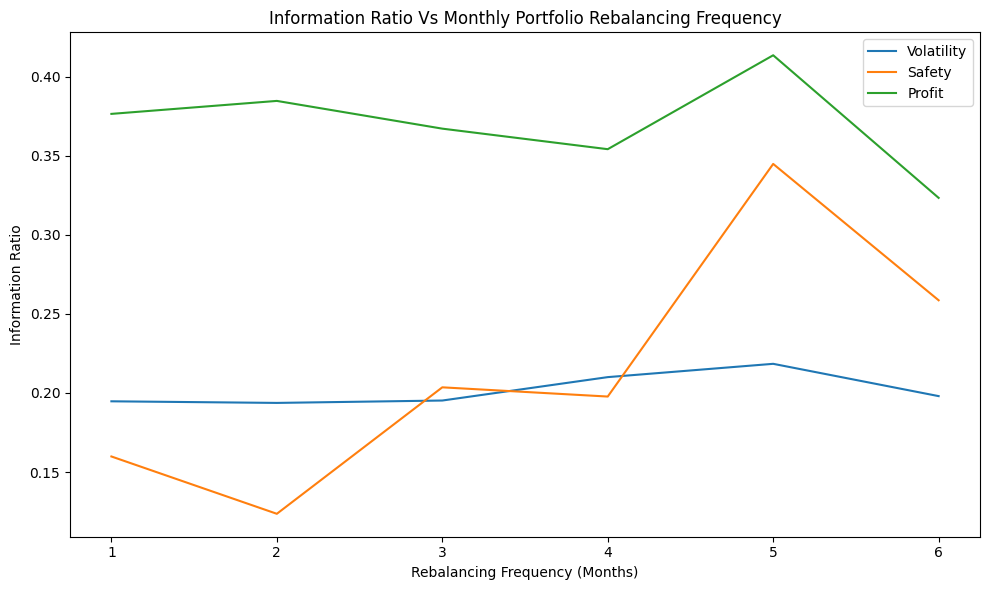

In [266]:
ir_values_plot = ir_values.plot(figsize=(10, 6))
ir_values_plot.set_title("Information Ratio Vs Monthly Portfolio Rebalancing Frequency")
ir_values_plot.set_ylabel("Information Ratio")
ir_values_plot.set_xlabel("Rebalancing Frequency (Months)")

legend_map = {
        "tvol" : "Volatility",
        "safety" : "Safety",
        "profit" : "Profit",
}
handles, labels = ir_values_plot.get_legend_handles_labels()
ir_values_plot.legend(handles, [legend_map.get(l, l) for l in labels])
ir_values_plot.figure.savefig("ir_values_plot.png", dpi=150, bbox_inches='tight')
ir_values_plot.figure.tight_layout()

#need to check this why is it below 0.5?

5. OPTIMAL FACTOR COMBINATION


In [271]:
combo_data = factors.join(future_returns.to_frame())


dflt_fac_w = 1/3
fac_cols = ['tvol', 'profit', 'safety']
weight_cols = [f'{fac_cols[i]}_w' for i in range(len(fac_cols))]

def monthly_ic(df, factor):
    # df indexed by ['id','date'] with columns [factor, 'fut_ret']
    # Spearman IC per month (cross-sectional)
    return (df[[factor, 'fut_ret']]
            .dropna()
            .groupby('date')
            .apply(lambda g: g[factor].corr(g['fut_ret'], method='spearman'))
            .rename(f'{factor}_IC'))

# # all factors in one table
ic_table = pd.concat([monthly_ic(combo_data, f) for f in fac_cols], axis=1)
# # optional: inspect summary stats
ic_summary = ic_table.agg(['mean','std','count'])
# factor_multi = ic_table.rolling(6, min_periods=3).mean().shift(1) + 1 #shift IC back one to avoid look ahead

#factor momentum statistical evidence
ic_persistence = ic_table.corrwith(ic_table.shift(1)) #closer to one means that high IC tends to be followed with high IC (predictive power)
print(ic_persistence) #we can see that tvol has the most factor persistance
# ic_table.tail()

# ic_smoothed = ic_table.rolling(6, min_periods=3).mean().shift(1)

combo_data = combo_data.join(ic_table.shift(1))
# combo_data = combo_data.join(ic_smoothed)

#backtesting
N = 300
frequency = 5
rt_cost = 0.0015

tvol_ic_multi = 0.25
profit_ic_multi = 0.25

train_start_date: str = '1990-01-01'
# train_end_date: str = '2014-12-31'
test_start_date: str = '2015-01-01'
test_end_date: str = '2023-12-29'

# train_start_date: str = '2015-01-01'
train_end_date: str = '2023-12-29'



val_range = np.linspace(0, 2, 100)
curr_multis = [0, 0, 0]
opt_multis = [0, 0, 0]
max_res = [0, 0, 0]

skip_optimisation = False
if not skip_optimisation:

    for j in range(0, 5): #rerunning starting from the already optimised numbers
        for i in range(0, len(curr_multis)):
            for val in val_range:
                curr_multis[i] = val
                combo_data['ic_multi_combo'] = (
                    (combo_data['tvol']   * (1+curr_multis[0]*combo_data['tvol_IC'])) +
                    (combo_data['profit'] * (1+curr_multis[1]*combo_data['profit_IC'])) +
                    (combo_data['safety'] * (1+curr_multis[2]*combo_data['safety_IC']))
                )

                _, _, _, perf = ap.backtesting(combo_data['ic_multi_combo'], prices['price'], market_cap['market_cap'], start=train_start_date, end=train_end_date, frequency=frequency, t_cost=rt_cost, N=N)
                ir = perf.loc['RR Ratio', 'Active']
                print(f'testing: {val} for multi: {i}, ir: {ir}')
                if ir > max_res[i]:
                    max_res[i] = ir
                    opt_multis[i] = val
                    print(f'new optimal for value {i}: {val}')
                
            curr_multis[i] = opt_multis[i]

        print(f'optimal multiples: {opt_multis}')
    print(f'optimal multiples: {opt_multis}')





# combo_data['primitive_combo'] = combo_data['tvol']*dflt_fac_w + combo_data['profit']*dflt_fac_w + combo_data['safety']*dflt_fac_w 
# combo_data['ic_multi_combo'] = (
#     (combo_data['tvol']   * (1+tvol_ic_multi*combo_data['tvol_IC'])) +
#     (combo_data['profit'] * (1+profit_ic_multi*combo_data['profit_IC'])) +
#     combo_data['safety']
#     # (combo_data['safety'] * (1+combo_data['safety_IC'])).where(combo_data['safety_IC'] > 0, 0)
# )


# ret, turnover, comp, perf = ap.backtesting(combo_data['primitive_combo'], prices['price'], market_cap['market_cap'], start='1990-01-01', end='2023-12-31', frequency=frequency, t_cost=rt_cost, N=N)
# primitive_ir = perf.loc['RR Ratio', 'Active']
# ret_ic, turnover_ic, comp_ic, perf_ic = ap.backtesting(combo_data['ic_multi_combo'], prices['price'], market_cap['market_cap'], start='1990-01-01', end='2023-12-31', frequency=frequency, t_cost=rt_cost, N=N)
# ic_multi_ir = perf_ic.loc['RR Ratio', 'Active']

# print(f'primitive_ir: {primitive_ir}')
# print(f'ic_multi_ir: {ic_multi_ir}')


# print(turnover.mean())
# print(turnover_ic.mean())

# print(perf)
# print(perf_ic)





#optimal for 2015 - 2023 optimal multiples: [np.float64(0.22222222222222224), np.float64(0.38383838383838387), np.float64(0.14141414141414144)]
#opimal for full set #[np.float64(0.0), np.float64(1.4545454545454546), np.float64(0.4646464646464647)]




tvol_IC      0.134740
profit_IC    0.168800
safety_IC    0.004667
dtype: float64
testing: 0.0 for multi: 0, ir: 0.5714258447892571
testing: 0.020202020202020204 for multi: 0, ir: 0.5699503665701141
testing: 0.04040404040404041 for multi: 0, ir: 0.5646050336912551
testing: 0.06060606060606061 for multi: 0, ir: 0.5661490133918327
testing: 0.08080808080808081 for multi: 0, ir: 0.5684948398119027
testing: 0.10101010101010102 for multi: 0, ir: 0.5632001775616895
testing: 0.12121212121212122 for multi: 0, ir: 0.5622411757833423
testing: 0.14141414141414144 for multi: 0, ir: 0.5568228675986706
testing: 0.16161616161616163 for multi: 0, ir: 0.5601179534237651
testing: 0.18181818181818182 for multi: 0, ir: 0.5605624879322434
testing: 0.20202020202020204 for multi: 0, ir: 0.5612971863475374
testing: 0.22222222222222224 for multi: 0, ir: 0.5550597990220218
testing: 0.24242424242424243 for multi: 0, ir: 0.5537581334386036
testing: 0.26262626262626265 for multi: 0, ir: 0.55143693956636
testing: 0.2

KeyboardInterrupt: 

In [276]:
#diagnostics of optimised factor momentum
# combo_data['ic_multi_combo'] = (
#             (combo_data['tvol']   * (1+0.222*combo_data['tvol_IC'])) +
#             (combo_data['profit'] * (1+0.3838*combo_data['profit_IC'])) +
#             (combo_data['safety'] * (1+0.1414*combo_data['safety_IC']))
#         )

combo_data['ic_multi_combo'] = (
            (combo_data['tvol']   * (1+0.262*combo_data['tvol_IC'])) +
            (combo_data['profit'] * (1+1.5151*combo_data['profit_IC'])) +
            (combo_data['safety'] * (1+0.4646*combo_data['safety_IC']))
        )

combo_data['simple_combo'] = (
            (combo_data['tvol']   * (1+0*combo_data['tvol_IC'])) +
            (combo_data['profit'] * (1+0*combo_data['profit_IC'])) +
            (combo_data['safety'] * (1+0*combo_data['safety_IC']))
        )



factor_combo_rets, _, _, perf = ap.backtesting(combo_data['ic_multi_combo'], prices['price'], market_cap['market_cap'], start=train_start_date, end=train_end_date, frequency=frequency, t_cost=rt_cost, N=N)
print(perf)

#individual factors
tvol_ret, _, _, _ = ap.backtesting(combo_data['tvol'], prices['price'], market_cap['market_cap'], start=train_start_date, end=train_end_date, frequency=frequency, t_cost=rt_cost, N=N)
profit_ret, _, _, _ = ap.backtesting(combo_data['profit'], prices['price'], market_cap['market_cap'], start=train_start_date, end=train_end_date, frequency=frequency, t_cost=rt_cost, N=N)
safety_ret, _, _, _ = ap.backtesting(combo_data['safety'], prices['price'], market_cap['market_cap'], start=train_start_date, end=train_end_date, frequency=frequency, t_cost=rt_cost, N=N)


              Portfolio  Benchmark    Active
Mean Return    0.091942   0.071975  0.019967
St. Dev.       0.132006   0.140972  0.033513
RR Ratio       0.696498   0.510561  0.595809
% Positive     0.634804   0.634804  0.541667
Worst Month   -0.145358  -0.186303 -0.029301
Best Month     0.122624   0.109437  0.040945
Max DrawDown  -0.492276  -0.608557 -0.064576


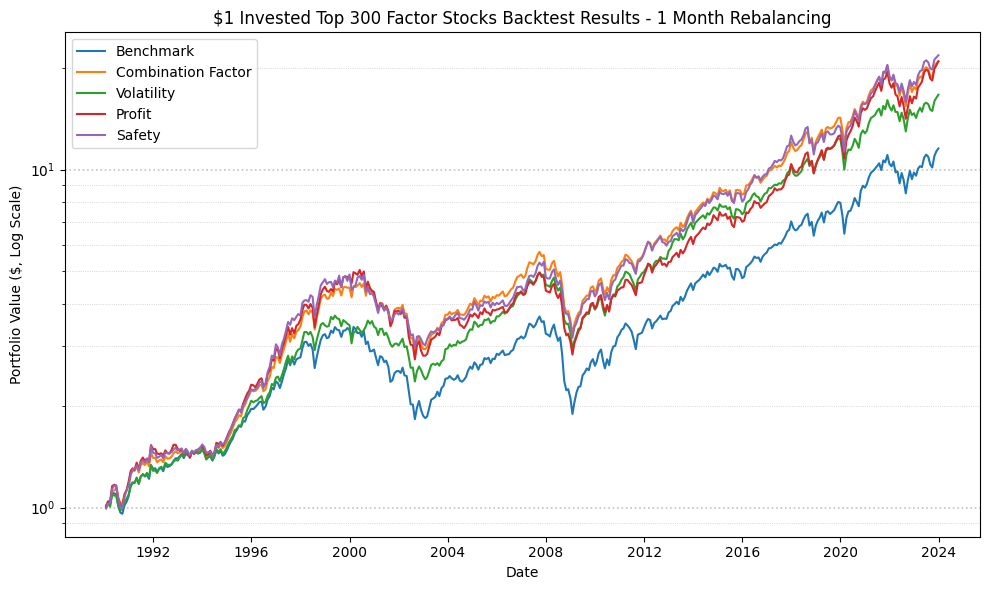

In [275]:
#

bench_port = combo_data['fut_ret'].loc['1990-01-01':].groupby('date').mean().loc['1990-01-01':].cumsum().apply(np.exp).to_frame()
factor_combo_port = factor_combo_rets['Portfolio'].cumsum().apply(np.exp).to_frame()
tvol_port = tvol_ret['Portfolio'].cumsum().apply(np.exp).to_frame()
profit_port = profit_ret['Portfolio'].cumsum().apply(np.exp).to_frame()
safety_port = safety_ret['Portfolio'].cumsum().apply(np.exp).to_frame()

bench_port.head()

plot_df = pd.DataFrame()
plot_df['Benchmark'] = bt_plot_perf['Benchmark']
plot_df['Combination Factor'] = factor_combo_port['Portfolio']
plot_df['Volatility'] = tvol_port['Portfolio']
plot_df['Profit'] = profit_port['Portfolio']
plot_df['Safety'] = safety_port['Portfolio']

one_dollar_invested_plot(plot_df, "$1 Invested Top 300 Factor Stocks Backtest Results - 1 Month Rebalancing", save_as="combination factor graph")

6. MACHINE LEARNING FACTOR INVESTING APPROACH

                     0         1  Benchmark    Active   Neutral
Mean Return  -0.028216  0.057543   0.017079  0.040464  0.085759
St. Dev.      0.245578  0.173608   0.204071  0.049543  0.105132
RR Ratio     -0.114896  0.331455   0.083691  0.816761  0.815730
% Positive    0.518519  0.620370   0.564815  0.648148  0.648148
Worst Month  -0.335507 -0.213798  -0.272953 -0.050638 -0.108292
Best Month    0.203964  0.136353   0.168014  0.059155  0.121709
Max DrawDown -0.573584 -0.351279  -0.439564 -0.172271 -0.365832
in sample accuracy: 0.5205771738624191, out of sample accuracy: 0.5180845089311908
feature_importance: 
                 Feature Importance
tvol                      0.580684
profit                    0.052428
safety                    0.000000
tvol_IC                   0.156663
profit_IC                 0.000000
safety_IC                 0.000000
ic_multi_combo            0.210226


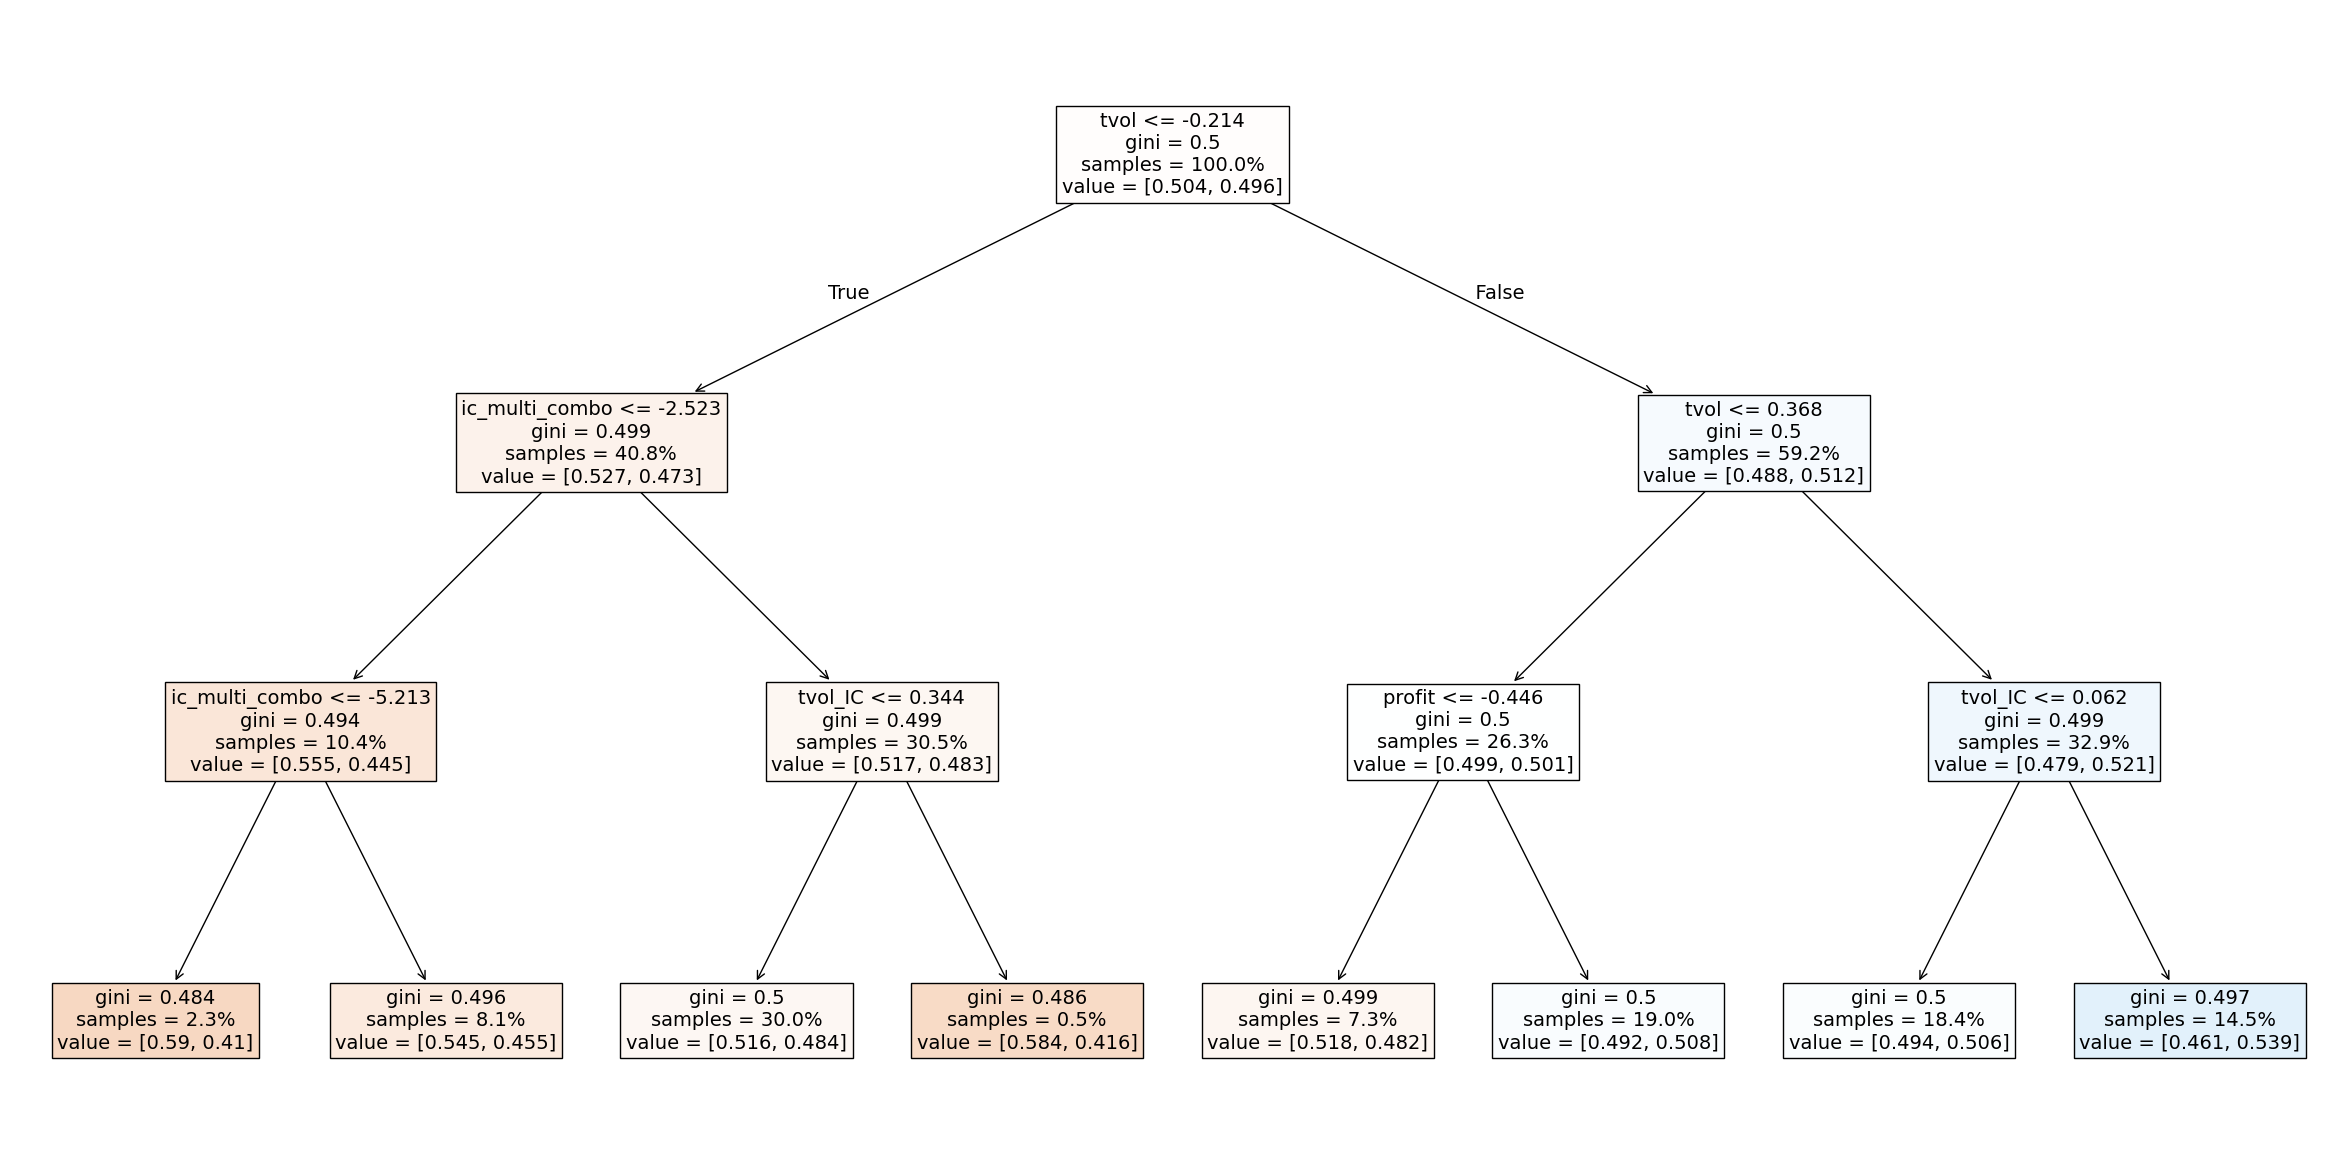

In [ ]:

#calculate a decision tree for combo data
clf, ins_accuracy, os_accuracy, ir, feature_importance, x_cols_list = train_tree(combo_data, depth=3)
plt.figure(figsize=(30,15))
tree.plot_tree(clf, fontsize=14, feature_names = x_cols_list, filled=True, proportion=True)
print(f'feature_importance: \n {feature_importance}')


In [ ]:
combo_data_inf = combo_data.join(inflation['Inflation'])


                     0         1  Benchmark    Active   Neutral
Mean Return  -0.028216  0.057543   0.017079  0.040464  0.085759
St. Dev.      0.245578  0.173608   0.204071  0.049543  0.105132
RR Ratio     -0.114896  0.331455   0.083691  0.816761  0.815730
% Positive    0.518519  0.620370   0.564815  0.648148  0.648148
Worst Month  -0.335507 -0.213798  -0.272953 -0.050638 -0.108292
Best Month    0.203964  0.136353   0.168014  0.059155  0.121709
Max DrawDown -0.573584 -0.351279  -0.439564 -0.172271 -0.365832
in sample accuracy: 0.5205771738624191, out of sample accuracy: 0.5180845089311908
feature_importance: 
                 Feature Importance
tvol                      0.574667
profit                    0.051885
safety                    0.000000
tvol_IC                   0.124445
profit_IC                 0.000000
safety_IC                 0.000000
ic_multi_combo            0.208047
Inflation                 0.040956
['tvol', 'profit', 'safety', 'tvol_IC', 'profit_IC', 'safety_IC', 'i

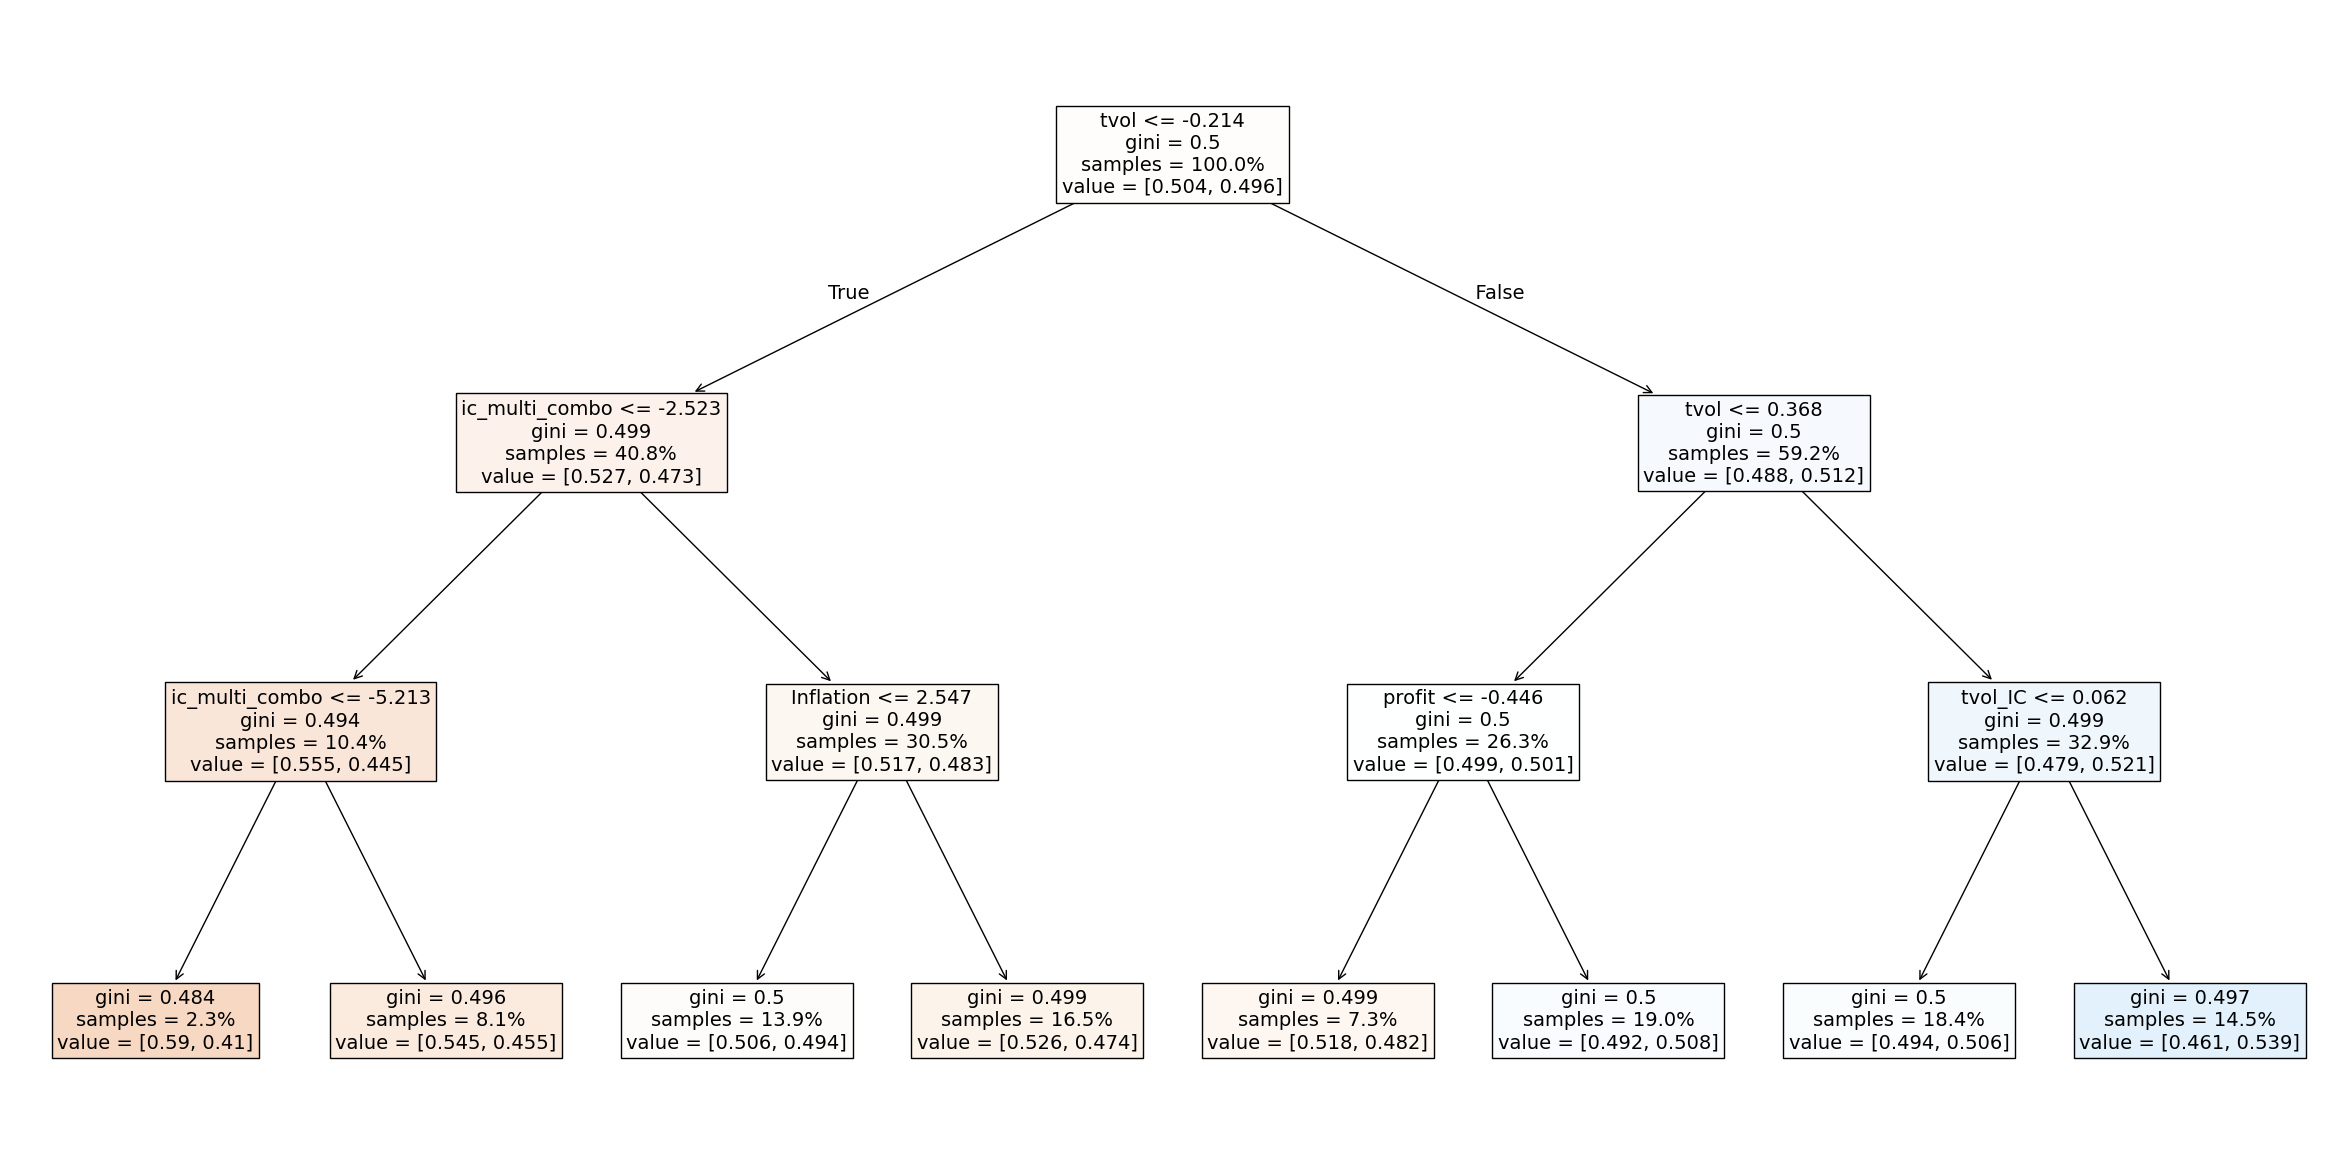

In [ ]:
#re run tree with inflation variable
clf, ins_accuracy, os_accuracy, ir, feature_importance, x_cols_list = train_tree(combo_data_inf, depth=3)
plt.figure(figsize=(30,15))
tree.plot_tree(clf, fontsize=14, feature_names = x_cols_list, filled=True, proportion=True)
print(f'feature_importance: \n {feature_importance}')
print(x_cols_list)

In [ ]:


combo_data_infchg = combo_data.join(inflation['Inflation'])
combo_data_infchg['inf_chng'] = combo_data_infchg['Inflation']/combo_data_infchg['Inflation'].shift(1) - 1
# combo_data_infchg = combo_data_infchg.drop(columns=['Inflation'])
combo_data_infchg.head()

tvol    profit    safety   fut_ret   tvol_IC  profit_IC  \
id    date                                                                      
10001 1996-07-31  1.145514 -0.612134 -0.475430  0.037458  0.244678   0.054430   
      1996-08-30  1.144505 -0.614493 -0.553341  0.040916  0.019485   0.076054   
      1996-09-30  1.144190 -1.327119 -0.697980 -0.028987  0.029740   0.118991   
      1996-10-31  1.124252 -1.324461 -0.728012  0.028988  0.136196   0.053431   
      1996-11-29  1.123180 -1.321322 -0.721799 -0.061268  0.124002   0.071222   

                  safety_IC  ic_multi_combo  Inflation  inf_chng  
id    date                                                        
10001 1996-07-31   0.118534        0.099417   3.083473       NaN  
      1996-08-30   0.058823       -0.040918   3.063090 -0.006610  
      1996-09-30   0.108931       -0.944713   2.943742 -0.038963  
      1996-10-31   0.123589       -0.934112   2.980390  0.012450  
      1996-11-29   0.087373       -0.934057   3.056422  0.025511

                     0         1  Benchmark    Active   Neutral
Mean Return  -0.028216  0.057543   0.017079  0.040464  0.085759
St. Dev.      0.245578  0.173608   0.204071  0.049543  0.105132
RR Ratio     -0.114896  0.331455   0.083691  0.816761  0.815730
% Positive    0.518519  0.620370   0.564815  0.648148  0.648148
Worst Month  -0.335507 -0.213798  -0.272953 -0.050638 -0.108292
Best Month    0.203964  0.136353   0.168014  0.059155  0.121709
Max DrawDown -0.573584 -0.351279  -0.439564 -0.172271 -0.365832
in sample accuracy: 0.5205771738624191, out of sample accuracy: 0.5180845089311908
feature_importance: 
                 Feature Importance
tvol                      0.574667
profit                    0.051885
safety                    0.000000
tvol_IC                   0.124445
profit_IC                 0.000000
safety_IC                 0.000000
ic_multi_combo            0.208047
Inflation                 0.040956
inf_chng                  0.000000
['tvol', 'profit', 'safety', 'tvo

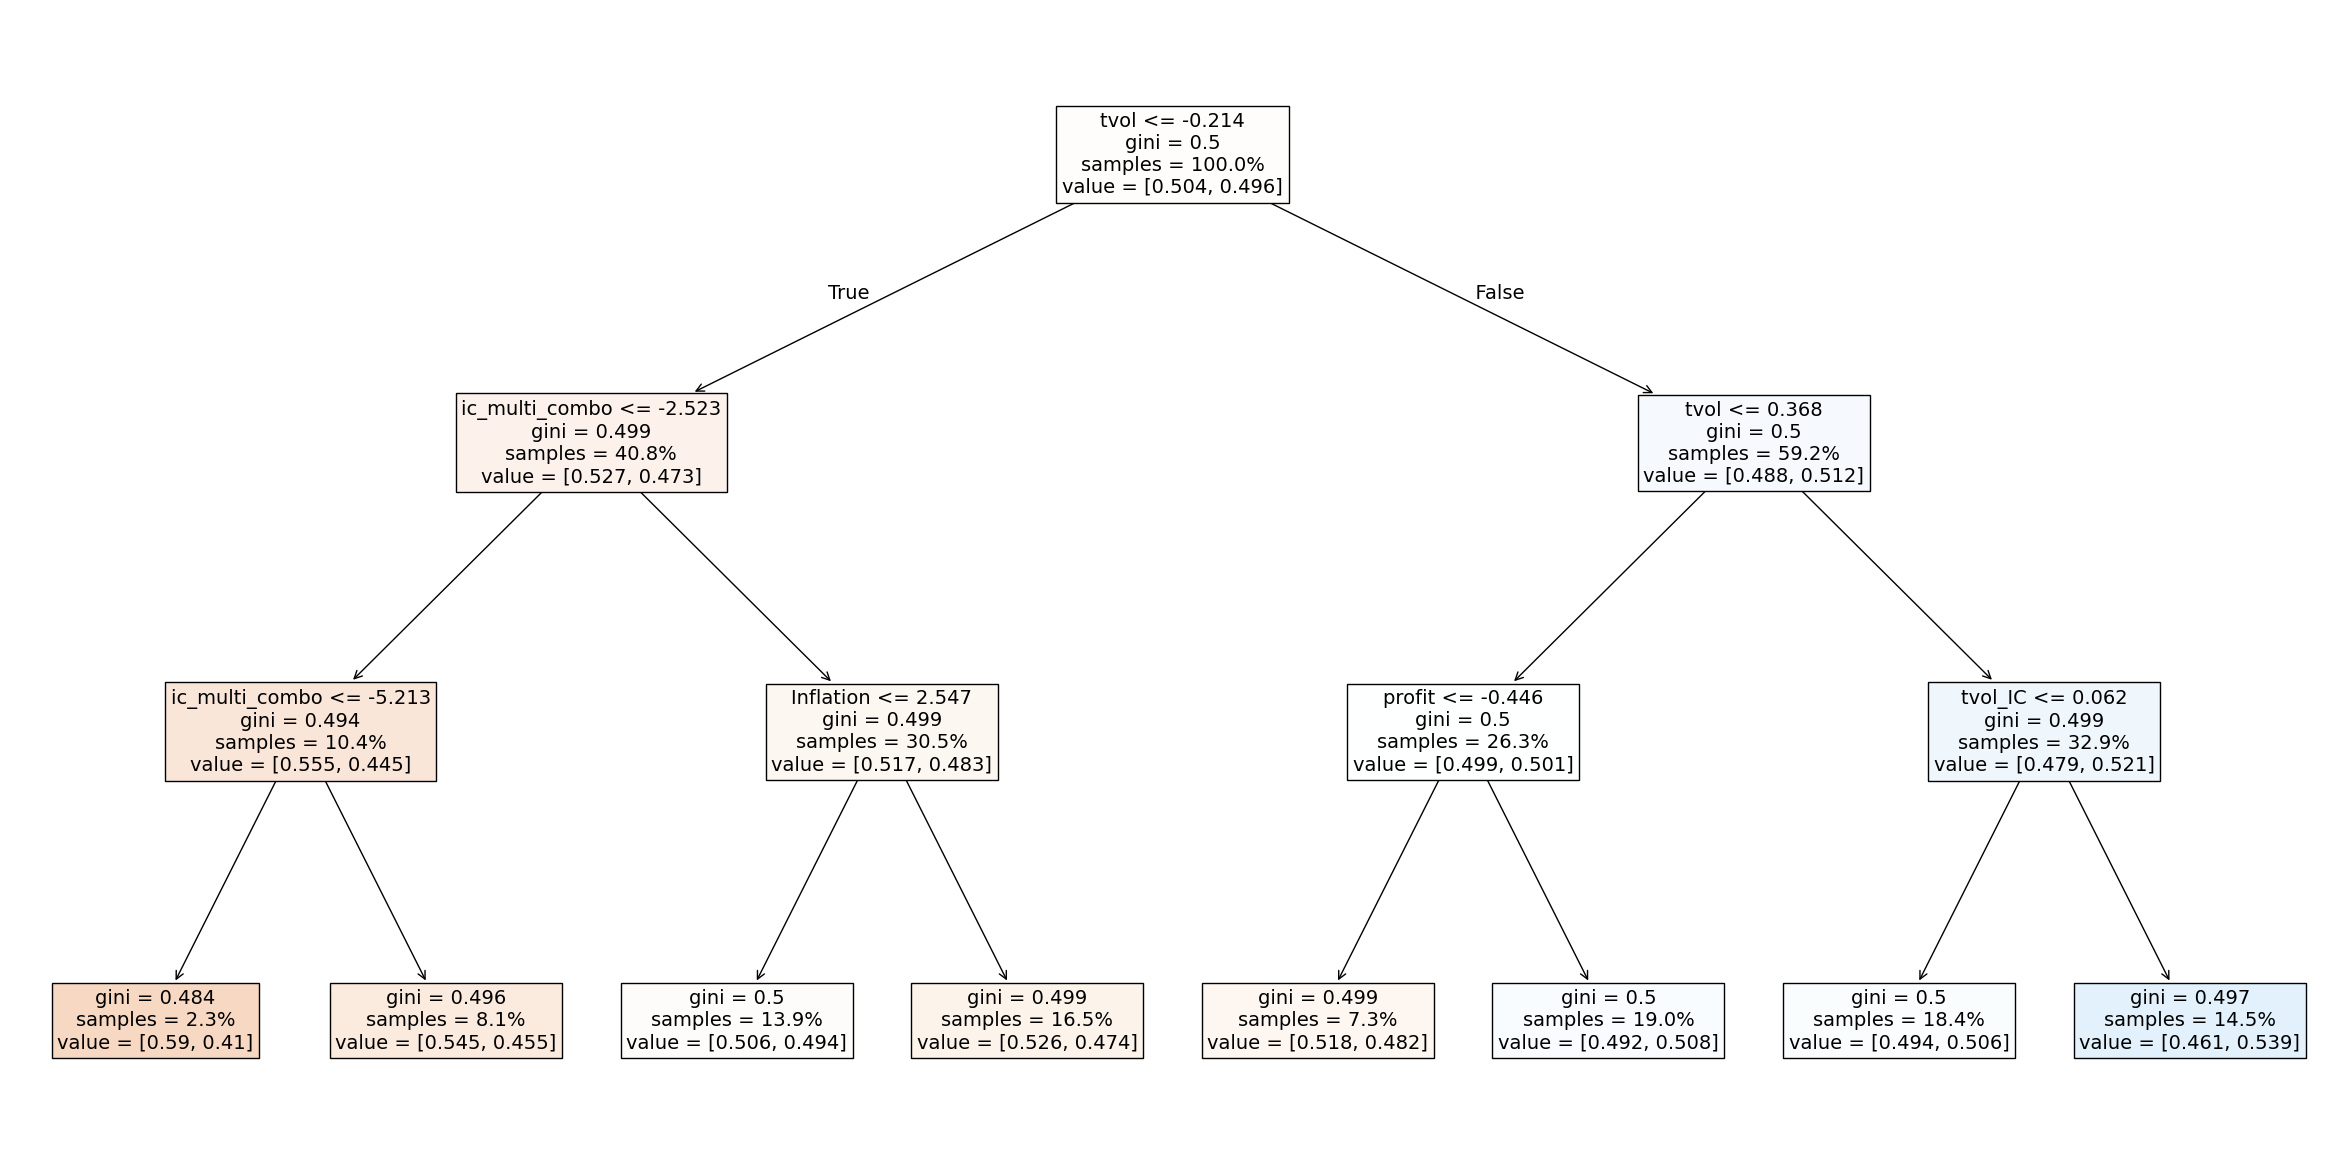

In [ ]:
#re run tree with inflation change
clf, ins_accuracy, os_accuracy, ir, feature_importance, x_cols_list = train_tree(combo_data_infchg)
plt.figure(figsize=(30,15))
tree.plot_tree(clf, fontsize=14, feature_names = x_cols_list, filled=True, proportion=True)
print(f'feature_importance: \n {feature_importance}')
print(x_cols_list)
